# Conclusion of the discoveries 

**If we use zero-mean random disturbance in the system, then the result will be the same as what we expect. However, if we use the positive constant disturbance, the transient trajectory composes of the majority of exploration, and the exploratory noise in control action contributes little. So to study the effect of learning, we need to set the system under zero-mean random disturbance.**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

## The plotting handler

In [2]:
def plot_with_errorband(ax,trial_data,indices = None,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [3]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

# Total LQR Cost vs $\bar{\eta}$

In [4]:
norm_order = 2
disturbance_name = ['Random Disturbance','Constant Disturbance']


def plot_by_disturbance(adv_disturbance,etas,control_alg,sample_plot_index = np.array([0])):
  

    data = {}

    costs = {alg:[] for alg in control_alg}

    A_errors = {alg:[] for alg in control_alg}
    B_errors = {alg:[] for alg in control_alg}

    for alg in control_alg:

        for eta in etas:
            with open('./data/{}_eta_{}_adv_{}.pkl'.format(alg,eta,adv_disturbance),'rb') as f:
                data[eta] = pkl.load(f)

        with open('./data/Parameters.pkl','rb') as f:
            data['Parameters'] = pkl.load(f)

        Q = data['Parameters']['Q']
        R = data['Parameters']['R']
        A = data['Parameters']['A']
        B = data['Parameters']['B']
        theta = np.concatenate([A,B],axis = -1)



        mean_cost = []
        std_cost = []

        for eta in etas:
            x_hist = np.array([d['x'] for d in data[eta]])
            u_hist = np.array([d['u'] for d in data[eta]])

            c = np.sum(cost(Q,x_hist),axis=-1)+np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis]),axis=-1)
            costs[alg].append(c)

        costs[alg] = np.array(costs[alg])



        ## Trajectory Plots



    for eta in etas[sample_plot_index]:
        plt.figure(dpi=200)
        ax = plt.gca()
        trial_data = [np.array(d['x'])[:,0].flatten() for d in data[eta]]

        plot_with_errorband(ax,trial_data,label=r'${}:\eta={}$'.format(disturbance_name[adv_disturbance],eta))

        ax.set_xlabel('t')
        ax.set_ylabel('x')
        ax.legend()



    for eta in etas[sample_plot_index]:
        plt.figure(dpi=200)
        ax = plt.gca()

        trial_data = [np.array(d['x'])[:,1].flatten() for d in data[eta]]

        plot_with_errorband(ax,trial_data,label=r'${}:\eta={}$'.format(disturbance_name[adv_disturbance],eta))

        ax.set_xlabel('t')
        ax.set_ylabel('v')
        ax.legend()



    for eta in etas[sample_plot_index]:
        plt.figure(dpi=200)
        ax = plt.gca()

        trial_data = [np.array(d['u']) for d in data[eta]]

        plot_with_errorband(ax,trial_data,label=r'${}:\eta={}$'.format(disturbance_name[adv_disturbance],eta))

        ax.set_xlabel('t')
        ax.set_ylabel('u')
        ax.legend()

    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),costs['PureExploration'].T,etas,disturbance_name[adv_disturbance])



    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel('LQR Cost')


    A_errors = []
    B_errors = []
    theta_errors = []



    for eta in etas:

        thetas = [d['theta'] for d in data[eta]]

        As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
        Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

        thetas  = [np.concatenate(t[-1],axis=-1) for t in thetas]

        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        theta_diff = np.linalg.norm(np.array(thetas)-theta,np.inf,axis=(-1,-2))
        A_diff = np.linalg.norm(As[:,-1,:,:]-A,norm_order,axis=(-1,-2))
        B_diff = np.linalg.norm(Bs[:,-1,:,:]-B,norm_order,axis=(-1,-2))


        theta_errors.append(theta_diff)
        A_errors.append(A_diff)
        B_errors.append(B_diff)



    theta_errors = np.array(theta_errors)
    A_errors = np.array(A_errors)
    B_errors = np.array(B_errors)



    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),theta_errors.T,etas,disturbance_name[adv_disturbance])

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel(r'$||\hat{\theta}-\theta||$')
    plt.show()

    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),A_errors.T,etas,disturbance_name[adv_disturbance])

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel(r'$||\hat{A}-A||_{\infty}$')
    plt.show()


    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),B_errors.T,etas,disturbance_name[adv_disturbance])

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel(r'$||\hat{B}-B||$')
    plt.show()




## Results under zero-mean random system disturbance

In [5]:
sample_plot_index = np.array([0,-1])
etas = np.array([0.1,0.5,1.0,2.0,4.0,10.0,20.0,40.0,60,80,100.0])
control_alg = ['PureExploration']
plot_by_disturbance(0,etas,control_alg,sample_plot_index)

FileNotFoundError: [Errno 2] No such file or directory: './data/PureExploration_eta_0.1_adv_0.pkl'

## Results under positive constant system disturbance

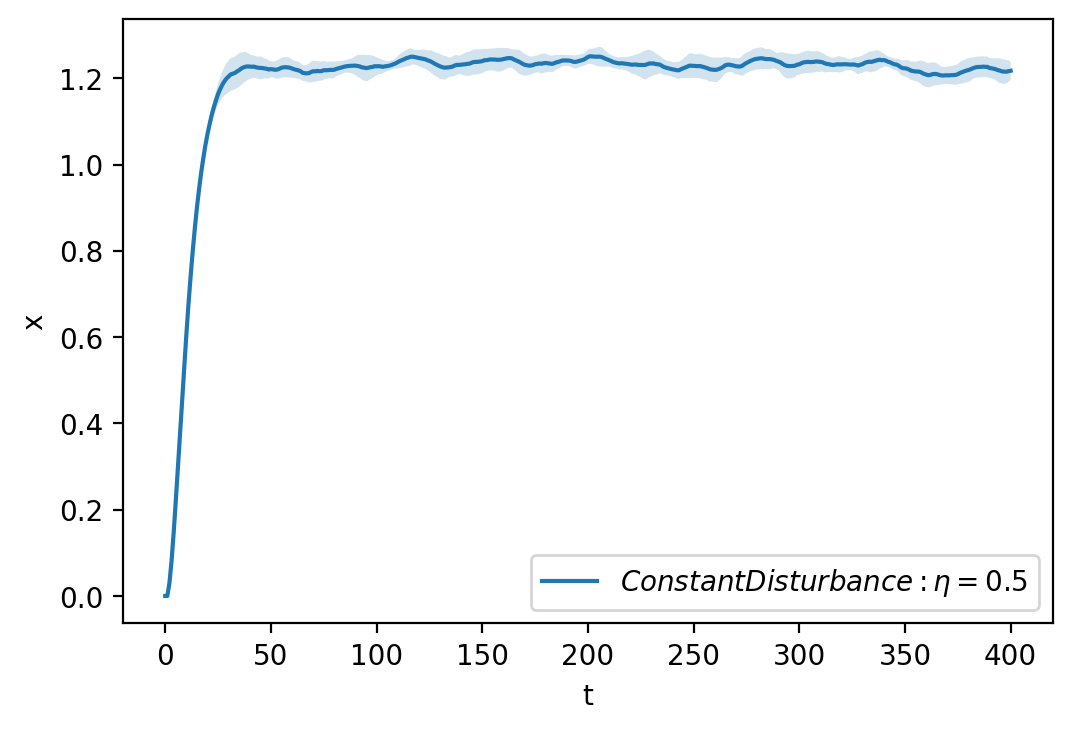

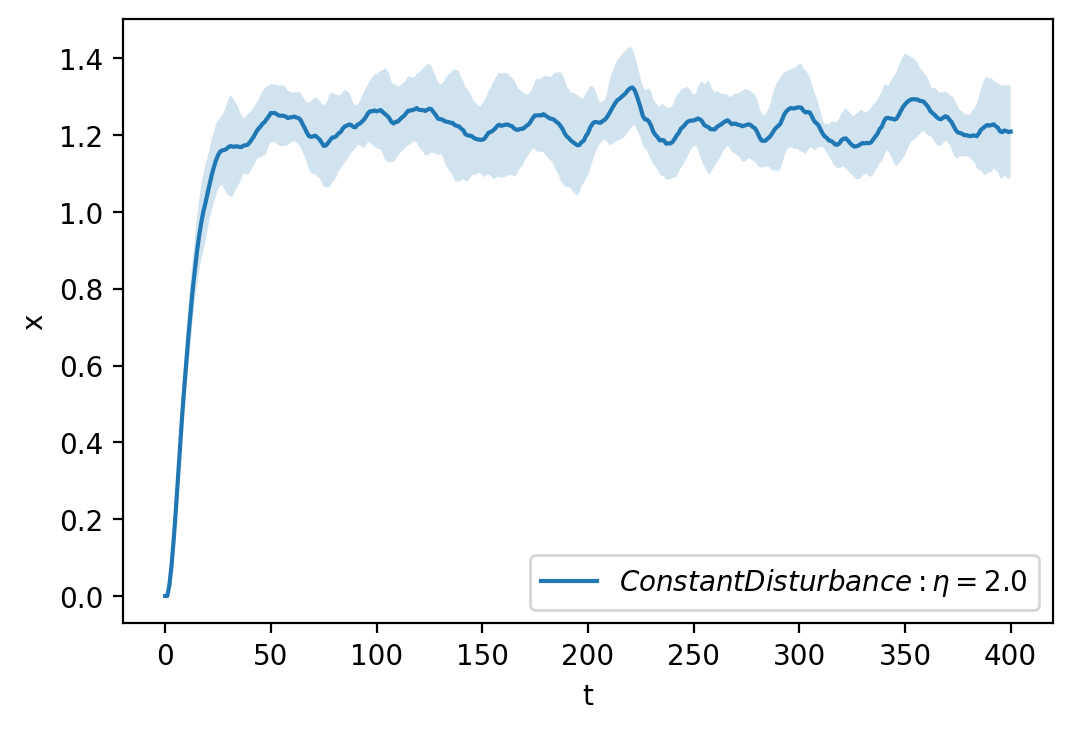

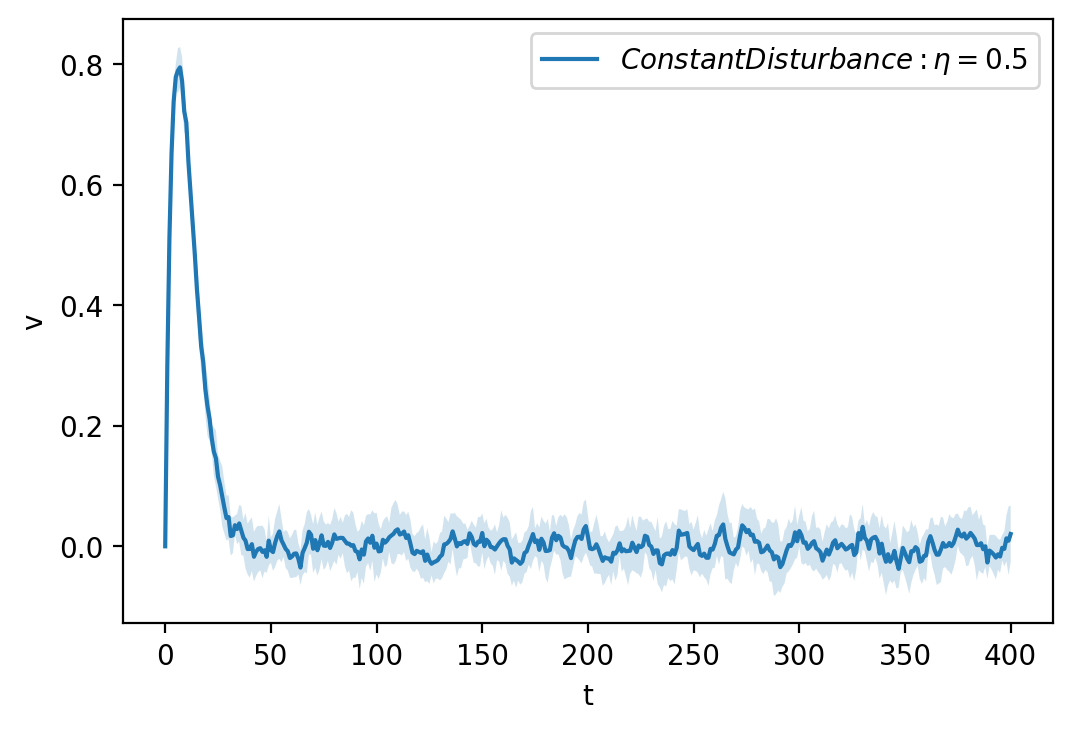

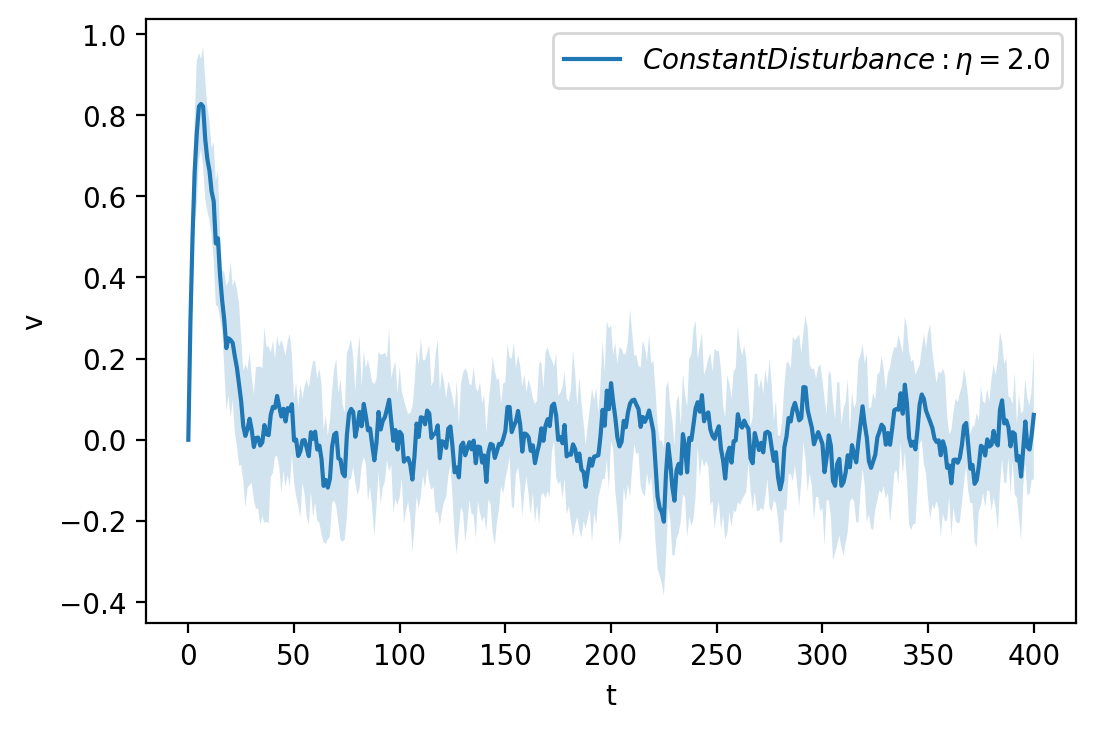

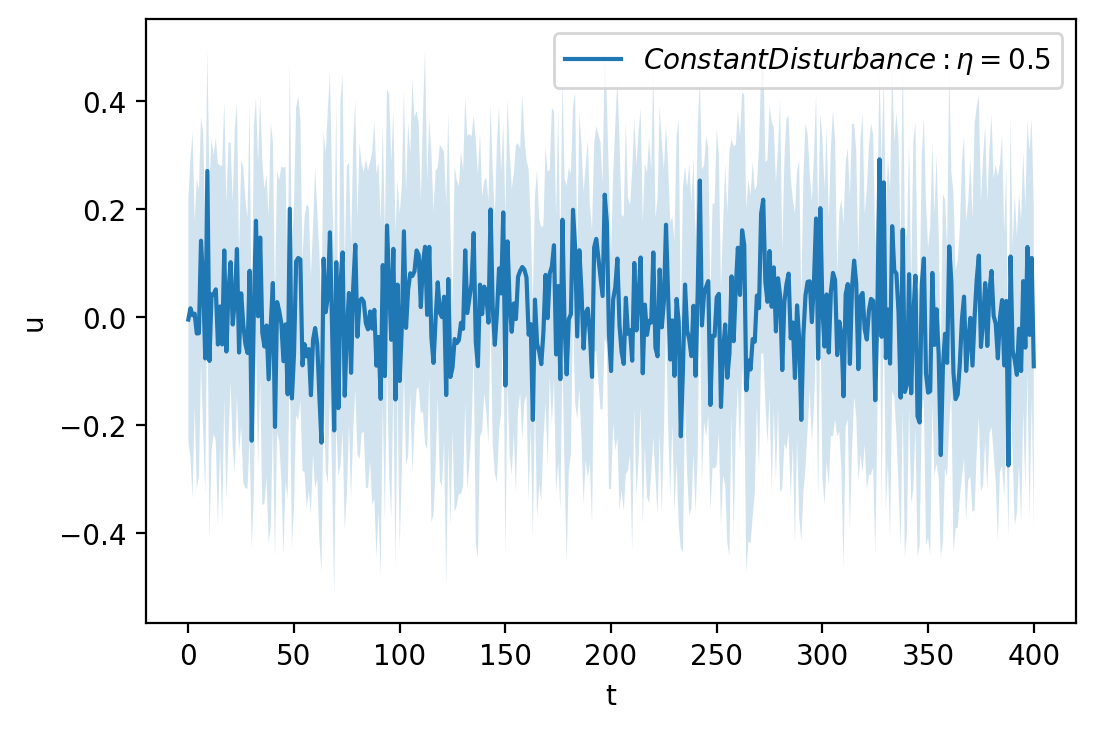

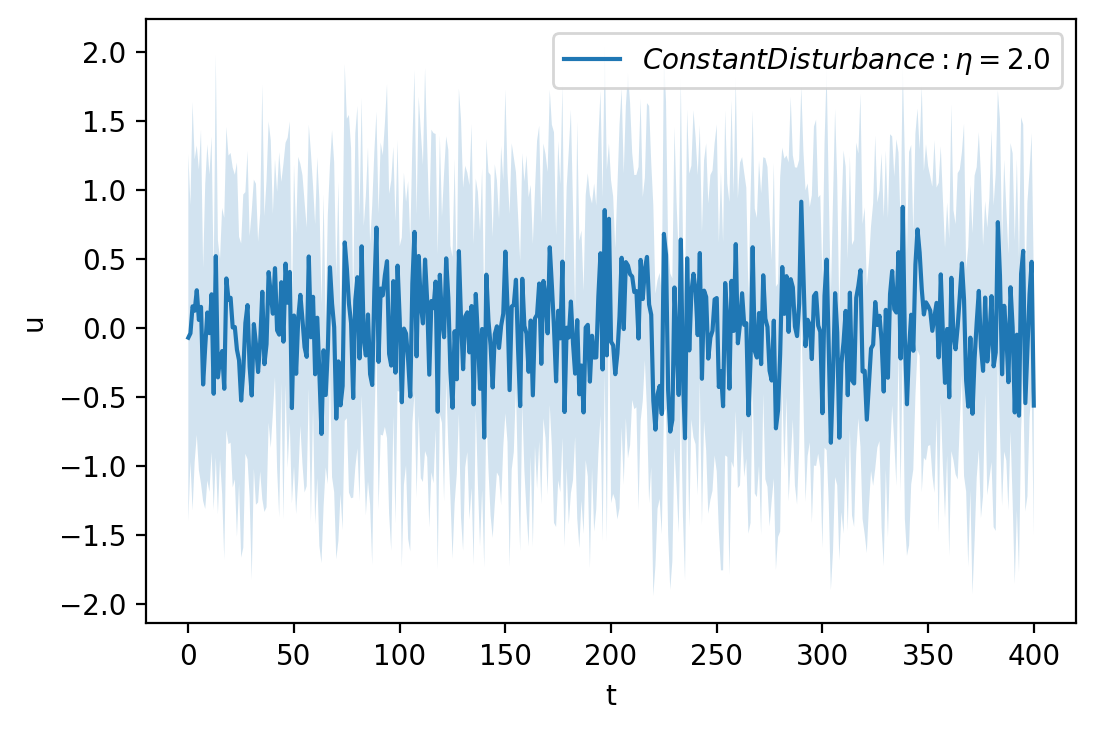

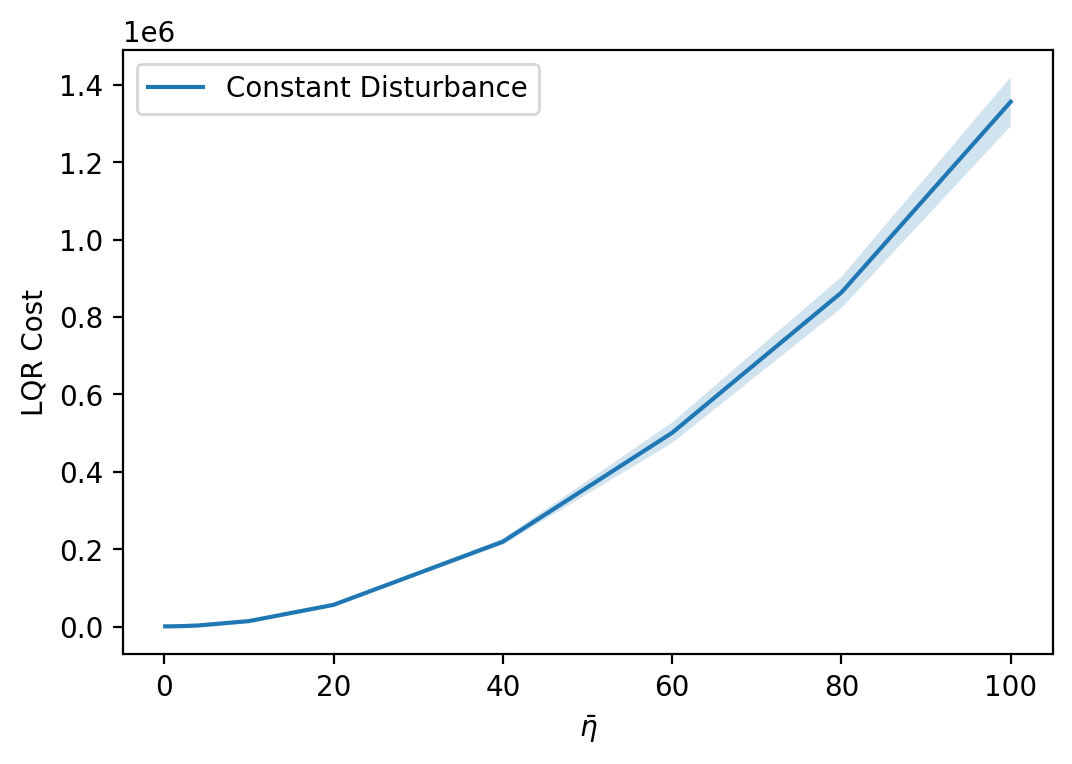

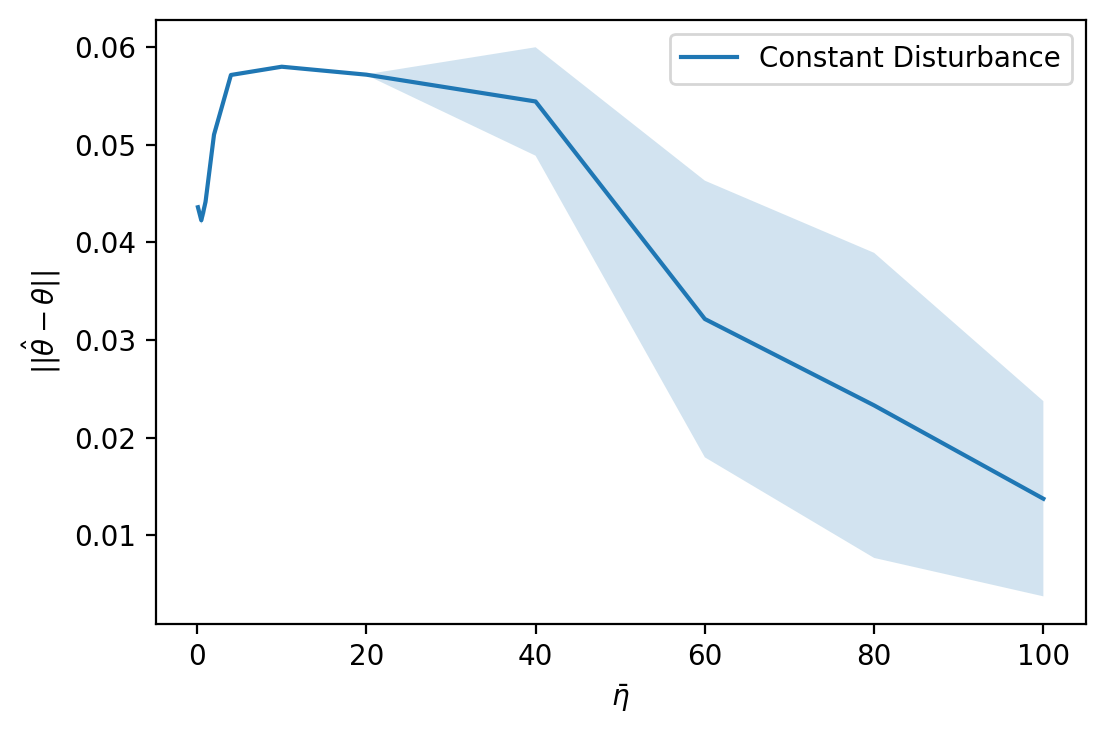

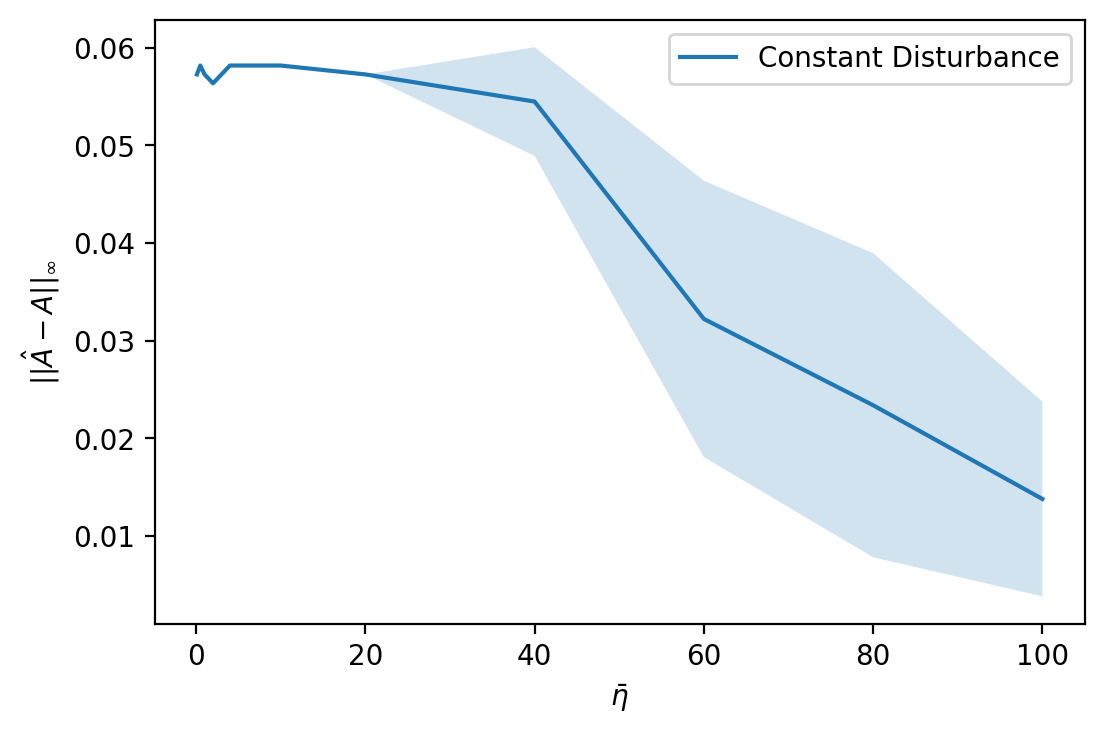

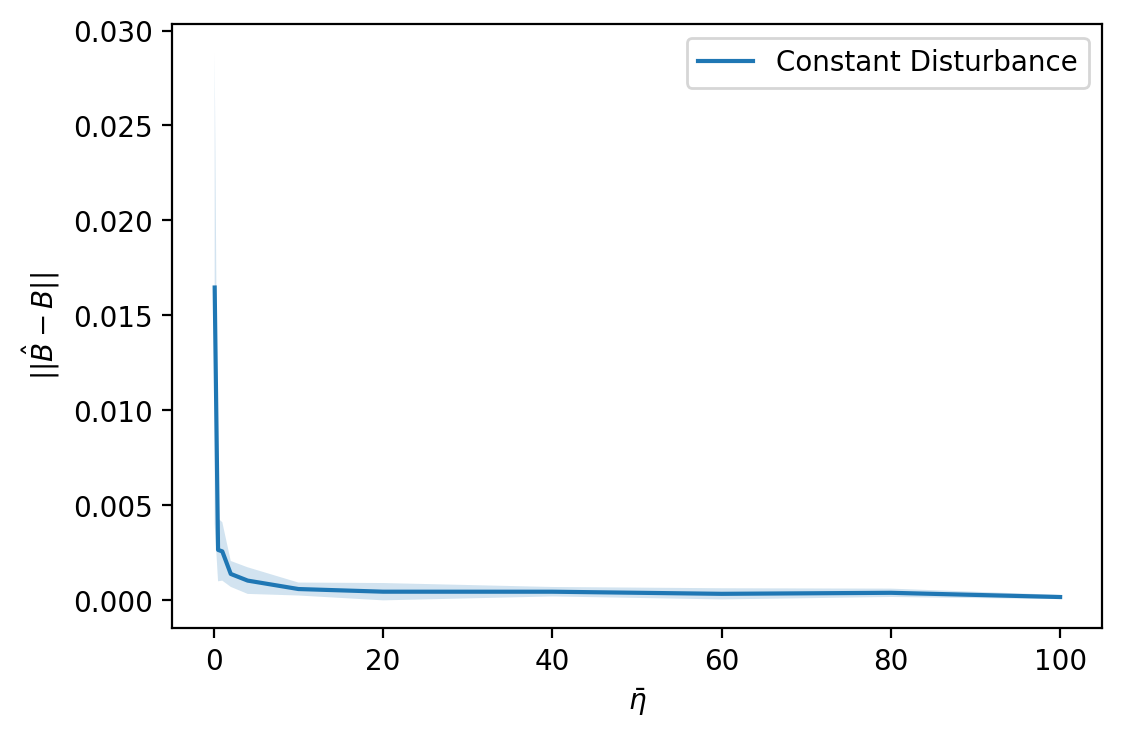

In [66]:
sample_plot_index = np.array([1,3])
control_alg = ['PureExploration']
plot_by_disturbance(1,etas,control_alg,sample_plot_index)